In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ast
import pandas as pd
from advanced_preprocessing import read_seperate_csv_from_zip, valid_velo_data_cropped

In [2]:
# Inititialize the time vector
fs = 20833.333333333332  # Sampling frequency in kHz
n = 4000 # Number of time-steps in the signal
T = n/fs # Total time duration

t = torch.linspace(0, T, n)  # Time vector

In [3]:
def frame_waves(data, length=500, labels=None, n_crops=1, jump=0):
    """
    Function that crops to the waves. Only works for data that is only v_out or v_in signals (mode).

    Args:
        data: numpy array or list with the voltage data of the bubbles
        labels: labels of the data. If n_crops=2, you must put in labels!
        length: amount of timesteps of the cropped part. Standard value is set at 500.
        n_crops: can be 1 or 2. For 1, makes one zoomed-in sample per bubble.
                For 2, picks two parts of the wave signal (so final output doubles in size)
        jump: Recommended value is an integer between 0-500 (for small lengths). 
                Gives the amount of steps away from the frame edge 
                (to obtain clearer waves, at the cost of possibly overshooting the bubble time frame)

    Output:
        cropped_data: Numpy array with the cropped voltages, dimension [#samples, length]
        labels: labels put in and duplicated to match the cropped_data. If n_crop=1,
        do not save the labels! Instead call the function using: cropped_data, _ = frame_waves(...)
        
    """
    if n_crops not in [1, 2]:
        raise ValueError("n_crops should be either 1 or 2")
    
    if not isinstance(data, np.ndarray):
        data = np.array(data)

    if n_crops == 1:
        cropped_data = np.array([sample[jump:(jump+length)] for sample in data])
    if n_crops == 2:
        cropped_data = np.array([sample[jump:(jump+length)] for sample in data])
        cropped_data2 = np.array([sample[(jump+length//2):(jump+length + length//2)] for sample in data])
        cropped_data = np.concatenate([cropped_data, cropped_data2])
        labels = np.concatenate([labels, labels])
    
    return cropped_data, labels

In [4]:
df = read_seperate_csv_from_zip("All_bubbles_2.2.zip")
#df = read_seperate_csv_from_zip("/kaggle/input/capstone2-2/60_2024-11-08T150426_bubbles.csv")

In [5]:
print(df.head())

            bubble_idx E_idx L_idx  VeloOut  \
0  0_2024-11-08T150426    E0    -1     -1.0   
1  1_2024-11-08T150426    E1    -1     -1.0   
2  2_2024-11-08T150426    E2    -1     -1.0   
3  3_2024-11-08T150426    E3    -1     -1.0   
4  4_2024-11-08T150426    E4    -1     -1.0   

                                          VoltageOut  FlowRate     Frequency  
0  [0.6185491681098938, 0.6185491681098938, 0.622...        60  2.083333e+07  
1  [0.5984679460525513, 0.5974303483963013, 0.601...        60  2.083333e+07  
2  [0.5890072584152222, 0.574175238609314, 0.5826...        60  2.083333e+07  
3  [0.5784478187561035, 0.5858333110809326, 0.595...        60  2.083333e+07  
4  [0.5942564010620117, 0.6048158407211304, 0.580...        60  2.083333e+07  


In [ ]:
X, y, idx = valid_velo_data_cropped(df, length=n, bubble_idx = True)
X = torch.Tensor(X)
y = torch.Tensor(y)

KeyError: 'voltage_exit'

In [10]:
def lowpass_filter(signal, fs, f_cutoff):
    fft_result = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(fft_result), d=1/fs)
    fft_result[np.abs(frequencies) > f_cutoff] = 0
    return np.fft.ifft(fft_result)

In [11]:
def transform_signal(signal: torch.Tensor, fs: float) -> list[torch.Tensor]:
    '''
    input:  signal (torch.Tensor) - the signal to be transformed
            fs (float) - the sampling frequency of the signal
            
    output: freq_out (torch.Tensor) - the frequency domain of the signal 
                    shape: [n//2]
            fft_out (torch.Tensor) - the fourier transform of the signal
                    shape: [#samples in, n//2]
    '''
    n = 4000

    if not isinstance(signal, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")

    if signal.dim() == 1 and signal.shape == torch.Size([n]):
        print(f'The input signal of shape {list(signal.shape)} was converted into shape [1 , {n}] for compatibility with the rest of the function. \nIf the purpose was to input only 1 sample, the output should be correct.\n')
        signal = signal.unsqueeze(0)
        
    
    # Ensure the tensor has at least 2 dimensions
    if signal.dim() != 2:
        raise ValueError(f"Input tensor must have 2 dimensions, but got {signal.dim()}.")
    
    # Validate the shape: second dimension must be n
    if signal.size(1) != n:
        raise ValueError(f"Input must have shape [*, {n}], but got {signal.size()}.")

    
    freq = torch.fft.rfftfreq(n, d=1/fs)
    fft = torch.fft.rfft(signal, axis=1)

    freq_out = freq[1: n+1]
    fft_out = torch.abs(fft)[:,1:n+1]
    
    return freq_out, fft_out


In [12]:
def find_peaks(frequencies, signal_fourier, peak_low = 15, peak_high = 500, stds = 5, plot = True):
    peak_freq = frequencies[torch.argmax(signal_fourier[:,peak_low:peak_high], dim=1) + peak_low]

    peak_height = torch.max(signal_fourier[:,peak_low:peak_high], dim=1).values
    peak_mean = torch.mean(signal_fourier, dim=1)
    peak_std = torch.std(signal_fourier, dim=1)
    peak_range_high = peak_mean + stds * peak_std
    peak_range_low = peak_mean - stds * peak_std

    peak_height = torch.where(peak_height>peak_range_high, peak_height, -1)
    peak_freq = torch.where(peak_height>peak_range_high, peak_freq, 0)

    if not plot:
        return peak_freq
    
    return peak_freq, peak_height, peak_mean, peak_range_low, peak_range_high


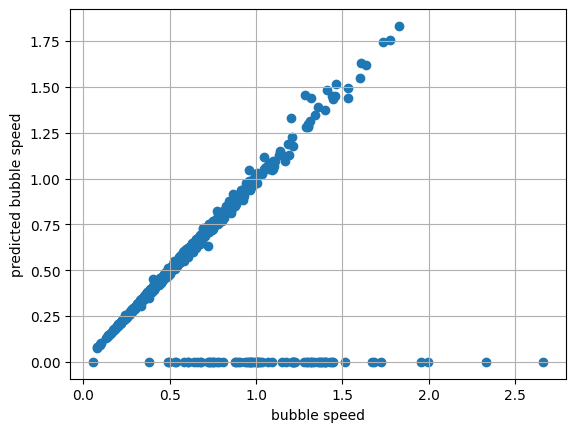

In [14]:
def predict_speed(f, lam=1550, n_gas=1.00027326, n_liq=1.333, in_bubble=True):
    '''
    f: detected peak frequency in Hz
    lam: wavelength of laser in nm (laser used by system that the software is designed for is 1550 nm)
    n: refractive index of medium (water: n = 1.333, air: n = 1.00027326)
    '''
    if in_bubble:
        n = n_gas

    v = ( f* 1e3) * (lam *1e-9) / (2 * n)

    return v

frequencies, signal_fourier = transform_signal(X, fs)
peak_freq = find_peaks(frequencies, signal_fourier, stds=8, plot=False)
v = predict_speed(peak_freq)

plt.scatter(y, v)
plt.xlabel('bubble speed')
plt.ylabel('predicted bubble speed')
plt.grid()
plt.show()

In [15]:
v_1 = predict_speed(peak_freq[0:10])
print(v_1)

tensor([0.6860, 0.5448, 0.7425, 0.1009, 0.9322, 0.3511, 0.6981, 0.3148, 0.0000,
        0.8676])


In [3]:
def plot_domains(t, signal, bubble_idx=None, plot_peak = True, plot_signal_lowpass = False, start=0, num=1, peak_low = 15, peak_high = 500, stds = 5):
    
    frequencies, signal_fourier = transform_signal(signal, fs)
    signal_lowpass = lowpass_filter(X, fs, 500)
    
    # Find the peak frequency and height
    #peak_freq = frequencies[torch.argmax(signal_fourier[:,peak_low:peak_high], dim=1) + peak_low]

    #peak_height = torch.max(signal_fourier[:,peak_low:peak_high], dim=1).values
    #peak_mean = torch.mean(signal_fourier, dim=1)
    #peak_std = torch.std(signal_fourier, dim=1)
    #peak_range_high = peak_mean + stds * peak_std
    #peak_range_low = peak_mean - stds * peak_std

    peak_freq, peak_height, peak_mean, peak_range_low, peak_range_high = find_peaks(frequencies, signal_fourier, peak_low=peak_low, peak_high=peak_high, stds=stds)
    
    # Plot the results
    plt.figure(figsize=(30, 5*num))
    for i in range(num):
        i_signal = start + i
        
        # Time-domain signal
        plt.subplot(num, 2, 1+2*i)
        plt.plot(t, signal[i_signal], linewidth=.25, color='k')
        if plot_signal_lowpass:
            plt.plot(t, signal_lowpass[i_signal], linewidth=.5, color='r', alpha=0.5)
        if bubble_idx is not None:
            plt.title(f"Time-Domain Signal of bubble: {bubble_idx[i_signal]}")
        else:
            plt.title("Time-Domain Signal")
        plt.xlabel("Time (ms)")
        plt.ylabel("Amplitude")
        plt.grid()

        # Frequency-domain signal
        plt.subplot(num, 2, 2+2*i)
        plt.plot(frequencies, signal_fourier[i_signal], linewidth=.5, color = 'k', label='Fourier transform of signal')
        if plot_peak:
            plt.axhline(peak_mean[i_signal], color = 'lightblue')
            plt.fill_between(frequencies, peak_range_low[i_signal], peak_range_high[i_signal], color='lightblue', alpha=0.5, label=f'mean ± {stds} standard deviations')
            plt.axvline(frequencies[peak_low], color='b', label=f'High pass for peak detection at: {round(float(frequencies[peak_low]), 2)} [kHz]')
            plt.axvline(frequencies[peak_high], color='b', label=f'Low pass for peak detection at: {round(float(frequencies[peak_high]), 2)} [kHz]')
            if peak_height[i_signal] == -1:
                plt.subplot(num, 2, 2+2*i)
                plt.text(1, peak_range_high[i_signal], f"No significant Peak \nWithin {stds} standard deviations", fontsize=12, color='white', va='top', bbox=dict(facecolor='blue', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.4))
            else:
                plt.scatter(peak_freq[i_signal], peak_height[i_signal], color='r', marker='x', label=f'peak at {round(float(peak_freq[i_signal]), 2)} [kHz]')
            plt.legend(loc=1)

        
        if bubble_idx is not None:
            plt.title(f"Frequency-Domain Signal of bubble: {bubble_idx[i_signal]}")
        else:
            plt.title("Frequency-Domain Signal")
        plt.xlabel("Frequency (kHz)")
        plt.ylabel("Magnitude")
        plt.grid()

    plt.tight_layout()
    plt.show()

plot_domains(t,X, bubble_idx=idx, start=10, num =3, plot_signal_lowpass = False, stds = 2, peak_high = 700)

NameError: name 't' is not defined